![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [267]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-project3-datasets/cities.csv
/kaggle/input/sf-project3-datasets/cuisine_types.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [268]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [269]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [270]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [271]:
# загружаем датасеты с дополнительной информацией. Возможно, она окажется полезной.
df_cuisine_types = pd.read_csv('/kaggle/input/sf-project3-datasets/cuisine_types.csv')
df_cities = pd.read_csv('/kaggle/input/sf-project3-datasets/cities.csv')

In [272]:
df_cuisine_types.head()

,cuisine,cuisine_type
0,Vegetarian Friendly,Healthy
1,European,European
2,unknown,unknown
3,Mediterranean,Seafood
4,Italian,European_national


In [273]:
df_cuisine_types.rename(columns={'cuisine':'Cuisine Style'},inplace=True)

In [274]:
df_cities.head()

,city,lat,lon,population,is_capital
0,London,51.507351,-0.127758,9126366,1
1,Paris,48.856613,2.352222,2175601,1
2,Madrid,40.416775,-3.703790,3348536,1
3,Barcelona,41.385063,2.173404,1620343,0
4,Berlin,52.520008,13.404954,3669495,1


In [275]:
df_cities.rename(columns={'city':'City'},inplace=True)

In [276]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [277]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [278]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [279]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [280]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [281]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [282]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [284]:
# Создадим столбец
#data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [285]:
#data['Number_of_Reviews_isNAN']

In [286]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
#data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [287]:
df.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [288]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [289]:
#data.head(5)

In [290]:
def look_at(row):
    print('Уникальных значений (включая Nan): ', df[row].nunique(dropna=False),'\n')
    print('Value_counts:')
    print(df[row].value_counts(),'\n')
    print('Количество Nan:')
    print(df[row].isna().value_counts())
    return

#### Признак "Restaurant_id".

In [291]:
# Посмотрим на признак в первом приближении
look_at('Restaurant_id')

Уникальных значений (включая Nan):  13094 

Value_counts:
id_871      19
id_436      19
id_633      19
id_227      19
id_430      18
            ..
id_16274     1
id_8883      1
id_13507     1
id_11206     1
id_10347     1
Name: Restaurant_id, Length: 13094, dtype: int64 

Количество Nan:
False    50000
Name: Restaurant_id, dtype: int64


In [292]:
# Посмотрим на рестораны с одинаковым id
df[df['Restaurant_id'] == 'id_871']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
871,id_871,Berlin,NaN,5900.0,NaN,5.0,"[[], []]",/Restaurant_Review-g187323-d10057590-Reviews-K...,d10057590,0,0.0
10756,id_871,Milan,"['Chinese', 'Seafood', 'Vegetarian Friendly']",873.0,$$ - $$$,69.0,"[['My favourite Chinese Restaurant in Milan', ...",/Restaurant_Review-g187849-d8277124-Reviews-Ri...,d8277124,1,4.5
11172,id_871,Geneva,['International'],876.0,$$ - $$$,28.0,[['Wild Girls Mess - A place Where Staff igno....,/Restaurant_Review-g188057-d4462793-Reviews-BG...,d4462793,1,4.0
13239,id_871,Zurich,"['Bar', 'Pub']",875.0,NaN,3.0,"[['Schlager central'], ['04/11/2015']]",/Restaurant_Review-g188113-d7904953-Reviews-Pe...,d7904953,1,4.5
14275,id_871,Prague,"['Czech', 'European', 'Eastern European']",872.0,$,66.0,"[['Good food, reasonable prices, Czech beer t....",/Restaurant_Review-g274707-d4767690-Reviews-Re...,d4767690,1,4.5
15350,id_871,Krakow,"['Fast Food', 'European', 'Greek', 'Vegetarian...",872.0,$,98.0,"[['Good and Inexpensive!', 'Terrible service.'...",/Restaurant_Review-g274772-d1098630-Reviews-Ak...,d1098630,1,3.5
19209,id_871,Athens,NaN,873.0,NaN,9.0,"[['Crepexarchia', 'Filling and delicious food ...",/Restaurant_Review-g189400-d10110357-Reviews-C...,d10110357,1,4.5
21434,id_871,Berlin,"['Asian', 'Vegetarian Friendly', 'Gluten Free ...",872.0,$$ - $$$,37.0,"[['Honest, fun and so good!', 'Amazing!!'], ['...",/Restaurant_Review-g187323-d12165690-Reviews-M...,d12165690,1,4.5
30423,id_871,Munich,"['French', 'Mediterranean', 'European', 'Wine ...",879.0,$$$$,87.0,"[['I will go back next time when in Munich', '...",/Restaurant_Review-g187309-d1342532-Reviews-Le...,d1342532,1,4.5
32885,id_871,Barcelona,"['Mediterranean', 'Wine Bar', 'International',...",872.0,$$$$,102.0,"[['Great wine tasting', 'Excellent meal with a...",/Restaurant_Review-g187497-d7332637-Reviews-Bo...,d7332637,1,4.5


In [293]:
df[df['Restaurant_id'] == 'id_436']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
436,id_436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...,d5003144,0,0.0
12955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613,1,4.5
14674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362,1,4.0
16118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122,1,4.5
16215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365,1,4.5
17377,id_436,Luxembourg,['Asian'],437.0,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888,1,4.5
18168,id_436,Oslo,"['European', 'Scandinavian']",437.0,$$$$,51.0,"[['Stunning views over Oslo', 'Brilliant break...",/Restaurant_Review-g190479-d2036436-Reviews-Re...,d2036436,1,4.0
18497,id_436,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",437.0,$$ - $$$,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",/Restaurant_Review-g187849-d1553645-Reviews-Il...,d1553645,1,4.0
22554,id_436,Ljubljana,NaN,437.0,NaN,14.0,"[['Terrible staff and service', 'Disrespectful...",/Restaurant_Review-g274873-d12607480-Reviews-C...,d12607480,1,3.0
23313,id_436,Krakow,['Vegetarian Friendly'],437.0,$$ - $$$,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",/Restaurant_Review-g274772-d12404722-Reviews-R...,d12404722,1,4.5


Во-первых, не похоже, что рестораны с одинаковым id принадлежат к одной сети из-за разных кухонь.  
Во-вторых, очевидна взаимосвязь между id и Ranking в df_train.

In [294]:
df['restaurant_id_num'] = df['Restaurant_id'].apply(lambda x: int(x.replace('id_','')))
df[['restaurant_id_num','Ranking']].corr()

,restaurant_id_num,Ranking
restaurant_id_num,1.00000,0.82509
Ranking,0.82509,1.00000


In [295]:
df_train['restaurant_id_num'] = df_train['Restaurant_id'].apply(lambda x: int(x.replace('id_','')))
df_train[['restaurant_id_num','Ranking']].corr()

,restaurant_id_num,Ranking
restaurant_id_num,1.0,1.0
Ranking,1.0,1.0


#### Признак "City".

In [296]:
# Посмотрим на признак в первом приближении
look_at('City')

Уникальных значений (включая Nan):  31 

Value_counts:
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64 

Количество Nan:
False    50000
Name: City, dtype: int64


In [297]:
# Посмострим, совпадают ли города в df_train и df_test
df_train['City'].value_counts().index.sort_values() == df_train['City'].value_counts().index.sort_values()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

City - категориальный признак, состоящий из 31 города Европы.  
Пропусков нет.  
Т.к. городов не много, я посмотрел на каждый, нашел ошибку в названии города Porto.  
Кроме того, я составил небольшой дополнительный датасет по этим городам.

In [298]:
df['City'] = df['City'].replace('Oporto','Porto')

In [299]:
df = pd.merge(df, df_cities, how = 'left', on = 'City')
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_id_num,lat,lon,population,is_capital
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,48.856613,2.352222,2175601,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,60.169857,24.938379,657674,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2,55.953251,-3.188267,488100,1
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,3,51.507351,-0.127758,9126366,1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,4,48.148598,17.107748,432864,1


In [300]:
# Посчитаем количество ресторанов в датасете для каждого города
rest_count = pd.DataFrame(df['City'].value_counts()).reset_index()
rest_count.columns = ['City','rest_count_in_city']
df = pd.merge(df, rest_count, how = 'left', on = 'City')
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_id_num,lat,lon,population,is_capital,rest_count_in_city
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,48.856613,2.352222,2175601,1,6108
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,60.169857,24.938379,657674,1,475
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2,55.953251,-3.188267,488100,1,745
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,3,51.507351,-0.127758,9126366,1,7193
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,4,48.148598,17.107748,432864,1,380


One-Hot Encoding для City я применю в конце, чтобы не загромождать раньше времени таблицу

#### Признак "Cuisine Style".

In [301]:
# Посмотрим на признак в первом приближении
look_at('Cuisine Style')

Уникальных значений (включая Nan):  10732 

Value_counts:
['Italian']                                                                                                                 1332
['French']                                                                                                                  1019
['Spanish']                                                                                                                  860
['French', 'European']                                                                                                       503
['Cafe']                                                                                                                     500
                                                                                                                            ... 
['Polish', 'European', 'Eastern European', 'Soups', 'Vegetarian Friendly']                                                     1
['Mediterranean', 'Spanish', 'Delicates

Cuisine Style - сложносоставной категориальный признак.
Достаточно много пропущенных значений, я заменю их на unknown.

In [302]:
df['Cuisine Style'] = df['Cuisine Style'].fillna("['unknown']")

In [303]:
type(df['Cuisine Style'][0])

str

In [304]:
# Т.к. значения признака  хоть и принадлежат к классу Srting, но имеют формат списка.
# Чтобы спарсить значения воспользуюсь встроенной функцией eval(). В данном случае ее применение безопасно
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: eval(x))

In [305]:
cuisines = df.explode('Cuisine Style')['Cuisine Style'].value_counts()
cuisines

Vegetarian Friendly    14021
European               12561
unknown                11590
Mediterranean           7820
Italian                 7433
                       ...  
Fujian                     2
Salvadoran                 1
Xinjiang                   1
Burmese                    1
Latvian                    1
Name: Cuisine Style, Length: 126, dtype: int64

Кухонь всего 126 (включая unknown), можно посмотреть на них всех

In [306]:
def print_full(df):
    ''' Функция для отображения всех строк DataFrame '''
    import pandas as pd
    pd.set_option('display.max_rows', len(df))
    print(df)
    pd.reset_option('display.max_rows')

In [307]:
print_full(cuisines)

Vegetarian Friendly    14021
European               12561
unknown                11590
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Spanish                 3456
Pub                     3058
Cafe                    2883
Fast Food               2122
British                 1992
International           1966
Seafood                 1878
Japanese                1860
Central European        1727
American                1642
Sushi                   1450
Chinese                 1446
Portuguese              1385
Indian                  1328
Middle Eastern           980
Thai                     923
Wine Bar                 877
German                   820
Halal                    773
Greek                    768
Healthy                  758
Fusion                   748
Czech                    745
Steakhouse    

In [308]:
# Я вручную сгруппировал кухни по своему усмотрению, чтобы в дальнейшем применить multilabel encoding
df_cuisine_types

,Cuisine Style,cuisine_type
0,Vegetarian Friendly,Healthy
1,European,European
2,unknown,unknown
3,Mediterranean,Seafood
4,Italian,European_national
...,...,...
121,Salvadoran,American
122,Latvian,European_national
123,Yunnan,Asian_national
124,Burmese,Asian_national


In [309]:
# добавим столбец с типами предлагаемых кухонь
df['idx'] = df.index
df_tmp = pd.merge(df.explode('Cuisine Style')[['idx','Cuisine Style']], df_cuisine_types, on='Cuisine Style',how='left')
df_tmp.drop_duplicates(['idx','cuisine_type'], inplace=True)
df_tmp = df_tmp.groupby('idx')['cuisine_type'].apply(list).reset_index()
df = pd.merge(df, df_tmp, on='idx', how='left')
df.drop(['idx'], axis=1, inplace=True)
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_id_num,lat,lon,population,is_capital,rest_count_in_city,cuisine_type
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,48.856613,2.352222,2175601,1,6108,[Bar]
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,60.169857,24.938379,657674,1,475,"[European, European_national, Healthy]"
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2,55.953251,-3.188267,488100,1,745,[Healthy]
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,3,51.507351,-0.127758,9126366,1,7193,"[European_national, Seafood, European, Healthy]"
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,4,48.148598,17.107748,432864,1,380,"[European_national, Seafood, European, Healthy]"


In [310]:
# Также добавим признак количество предлагаемых кухонь
df['cuisine_count'] = df['Cuisine Style'].str.len()
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_id_num,lat,lon,population,is_capital,rest_count_in_city,cuisine_type,cuisine_count
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,48.856613,2.352222,2175601,1,6108,[Bar],2
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,60.169857,24.938379,657674,1,475,"[European, European_national, Healthy]",5
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2,55.953251,-3.188267,488100,1,745,[Healthy],1
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,3,51.507351,-0.127758,9126366,1,7193,"[European_national, Seafood, European, Healthy]",5
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,4,48.148598,17.107748,432864,1,380,"[European_national, Seafood, European, Healthy]",6


In [311]:
# Сейчас unknown считается за одну предлагаемую кухню. Исправим это.
df['missed_cuisine']=df['Cuisine Style'].apply(lambda x: 1 if x == ['unknown'] else 0)
df['cuisine_count'] = (1-df['missed_cuisine'])*df['cuisine_count']
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_id_num,lat,lon,population,is_capital,rest_count_in_city,cuisine_type,cuisine_count,missed_cuisine
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,48.856613,2.352222,2175601,1,6108,[Bar],2,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,60.169857,24.938379,657674,1,475,"[European, European_national, Healthy]",5,0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2,55.953251,-3.188267,488100,1,745,[Healthy],1,0
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,3,51.507351,-0.127758,9126366,1,7193,"[European_national, Seafood, European, Healthy]",5,0
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,4,48.148598,17.107748,432864,1,380,"[European_national, Seafood, European, Healthy]",6,0


#### Признак "Ranking".

In [312]:
# Посмотрим на признак в первом приближении
look_at('Ranking')

Уникальных значений (включая Nan):  12975 

Value_counts:
93.0       22
72.0       21
491.0      21
842.0      21
1013.0     20
           ..
8027.0      1
10415.0     1
14621.0     1
11766.0     1
10585.0     1
Name: Ranking, Length: 12975, dtype: int64 

Количество Nan:
False    50000
Name: Ranking, dtype: int64


In [313]:
df[df['Ranking'] == 93]['City'].value_counts()

Barcelona     1
Warsaw        1
Madrid        1
Milan         1
Paris         1
Ljubljana     1
Oslo          1
Stockholm     1
Zurich        1
Berlin        1
Geneva        1
Amsterdam     1
Krakow        1
Vienna        1
Porto         1
Edinburgh     1
Bratislava    1
Copenhagen    1
Dublin        1
London        1
Athens        1
Brussels      1
Name: City, dtype: int64

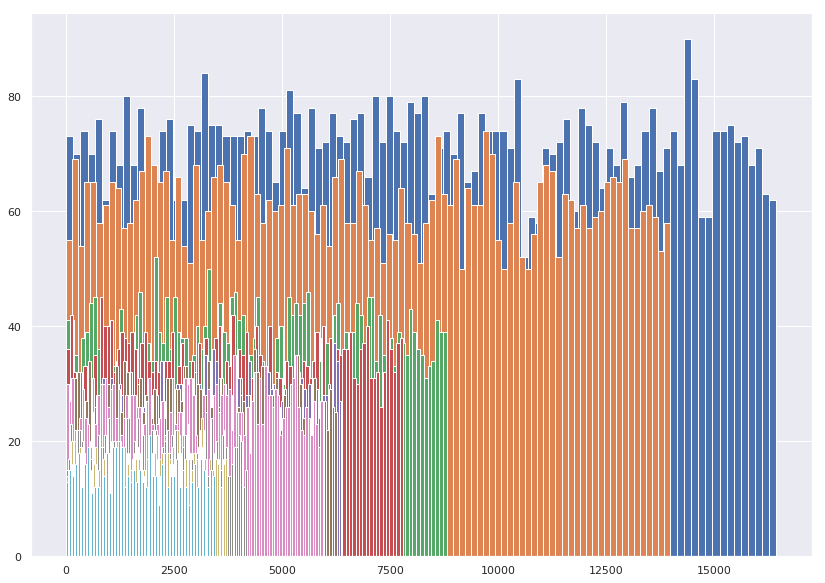

In [314]:
# посмотрим на топ 10 городов
plt.rcParams['figure.figsize'] = (14,10)
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [315]:
# Нет информации обо всех рангах для каждого города, вероятно из-за того, что не все растораны города присутствуют датасете TripAdvisor
print(df[df['City'] == 'London']['Ranking'].value_counts().index.sort_values(ascending = True)[0:10])
print(df[df['City'] == 'Madrid']['Ranking'].value_counts().index.sort_values(ascending = True)[0:10])
print(df[df['City'] == 'Berlin']['Ranking'].value_counts().index.sort_values(ascending = True)[0:10])

Float64Index([1.0, 6.0, 10.0, 11.0, 12.0, 13.0, 16.0, 17.0, 18.0, 20.0], dtype='float64')
Float64Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 10.0, 11.0, 16.0], dtype='float64')
Float64Index([2.0, 4.0, 9.0, 12.0, 14.0, 15.0, 20.0, 21.0, 22.0, 24.0], dtype='float64')


In [316]:
# Естественно сильно отличается последний ранг с общим количеством ресторанов в городе
print(df['Ranking'][df['City'] == 'London'].max())
print(len(df['Ranking'][df['City'] == 'London']))

16444.0
7193


Получается, что Ranking распределен равномерно, просто в больших городах больше ресторанов, из-за мы этого для каждого города своя верхняя граница ранга.
Для объективности картины нужно нормировать ранг.

In [317]:
# найдем максимальный ранг в каждом городе
max_rank = df.groupby(df['City'])['Ranking'].max().reset_index()
max_rank.rename(columns = {'Ranking':'max_rank_in_city'}, inplace=True)

# добавим эту информацию в наш датасет
df = pd.merge(df,max_rank, on='City',how='left')

# идея нормирования в данном случае такая: новый ранг ресторана на 1 месте равен единице, а новый ранг ресторана на последнем месте стремится к 0.
df['norm_rank'] = (df['max_rank_in_city']+1-df['Ranking'])/df['max_rank_in_city']
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,lat,lon,population,is_capital,rest_count_in_city,cuisine_type,cuisine_count,missed_cuisine,max_rank_in_city,norm_rank
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,48.856613,2.352222,2175601,1,6108,[Bar],2,0,13986.0,0.073216
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,60.169857,24.938379,657674,1,475,"[European, European_national, Healthy]",5,0,1141.0,0.907975
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,55.953251,-3.188267,488100,1,745,[Healthy],1,0,1766.0,0.541903
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,51.507351,-0.127758,9126366,1,7193,"[European_national, Seafood, European, Healthy]",5,0,16444.0,0.898565
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,48.148598,17.107748,432864,1,380,"[European_national, Seafood, European, Healthy]",6,0,889.0,0.959505


#### Признак "Price Range".

In [318]:
# Посмотрим на признак в первом приближении
look_at('Price Range')

Уникальных значений (включая Nan):  4 

Value_counts:
$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64 

Количество Nan:
False    32639
True     17361
Name: Price Range, dtype: int64


По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [319]:
# заменим категориальные признаки на ординальные.
# Пропуски заменим на среднюю цену, т.к. это самый популярный вариант
# Чтобы не потерялась информация о пропусках, предварительно создадим отдельный признак

df['missed_price_range'] = pd.isna(df['Price Range']).astype('uint8')

def price_range_ord(cell):
    if type(cell) == str:
        cell = cell.replace('$$$$', '3')
        cell = cell.replace('$$ - $$$', '2')
        cell = cell.replace('$', '1')
        cell = int(cell)
        return cell
    cell = 2
    return cell

df['Price Range'] = df['Price Range'].apply(price_range_ord)

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

In [ ]:
print(df['Price Range'].value_counts())
print(df['missed_price_range'].value_counts())

In [ ]:
# Чтобы не 

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [ ]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

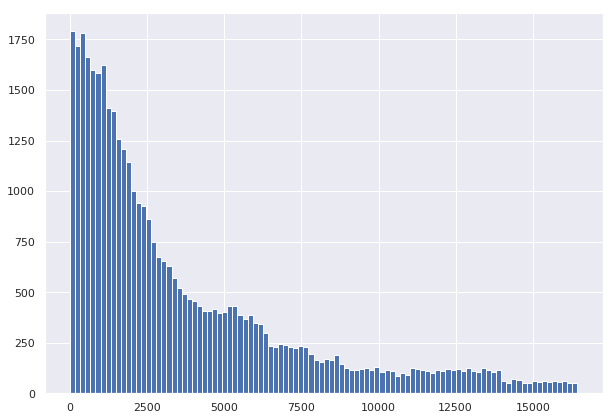

In [26]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

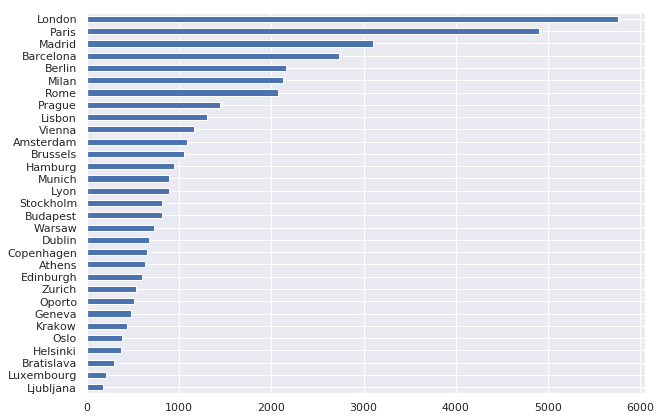

In [27]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

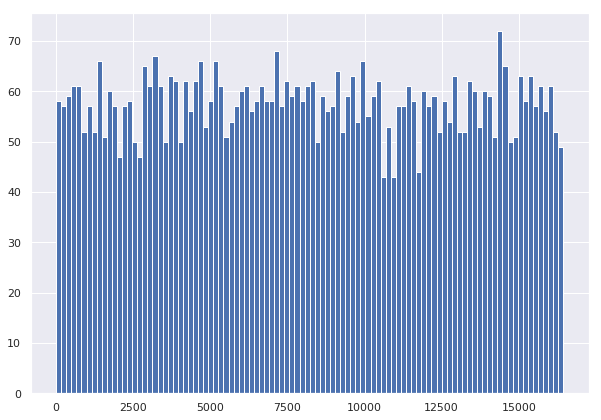

In [28]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

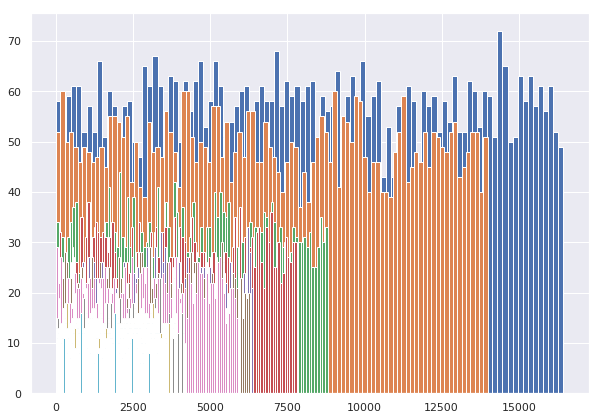

In [29]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [30]:
# Нет информации обо всех рангах для каждого города
print(df_train[df_train['City'] == 'London']['Ranking'].value_counts().index.sort_values(ascending = True))
print(df_train[df_train['City'] == 'Madrid']['Ranking'].value_counts().index.sort_values(ascending = True))
print(df_train[df_train['City'] == 'Berlin']['Ranking'].value_counts().index.sort_values(ascending = True))

Float64Index([    1.0,     6.0,    10.0,    11.0,    13.0,    16.0,    17.0,
                 18.0,    20.0,    23.0,
              ...
              16402.0, 16406.0, 16408.0, 16411.0, 16418.0, 16420.0, 16435.0,
              16437.0, 16441.0, 16444.0],
             dtype='float64', length=5757)
Float64Index([   1.0,    2.0,    3.0,    4.0,    6.0,    7.0,   10.0,   11.0,
                16.0,   20.0,
              ...
              8790.0, 8791.0, 8793.0, 8795.0, 8799.0, 8801.0, 8803.0, 8806.0,
              8808.0, 8809.0],
             dtype='float64', length=3108)
Float64Index([   2.0,    4.0,    9.0,   12.0,   14.0,   15.0,   20.0,   21.0,
                22.0,   24.0,
              ...
              6332.0, 6340.0, 6347.0, 6348.0, 6350.0, 6353.0, 6358.0, 6368.0,
              6370.0, 6372.0],
             dtype='float64', length=2155)


In [31]:
# Естественно сильно отличается последний ранг с общим количеством городов
print(df_train['Ranking'][df_train['City'] == 'London'].max())
print(len(df_train['Ranking'][df_train['City'] == 'London']))

16444.0
5757


In [32]:
df_train['Ranking'].value_counts()

1080.0     19
437.0      18
491.0      18
345.0      18
431.0      18
           ..
14711.0     1
9409.0      1
14109.0     1
10501.0     1
5699.0      1
Name: Ranking, Length: 11936, dtype: int64

In [33]:
df_train['City'][df_train['Ranking'] == 491].value_counts()

London        1
Bratislava    1
Barcelona     1
Budapest      1
Zurich        1
Munich        1
Madrid        1
Helsinki      1
Dublin        1
Hamburg       1
Luxembourg    1
Krakow        1
Geneva        1
Oslo          1
Vienna        1
Lyon          1
Paris         1
Athens        1
Name: City, dtype: int64

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

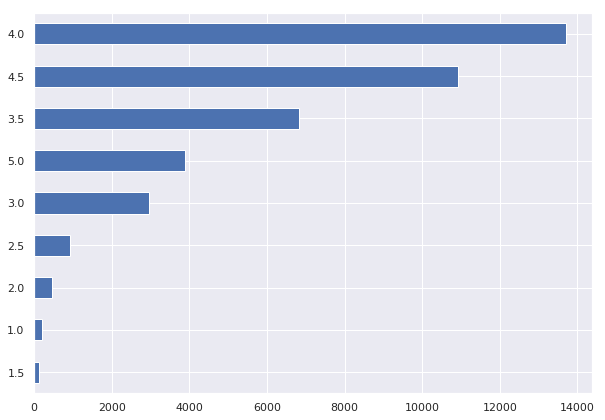

In [34]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

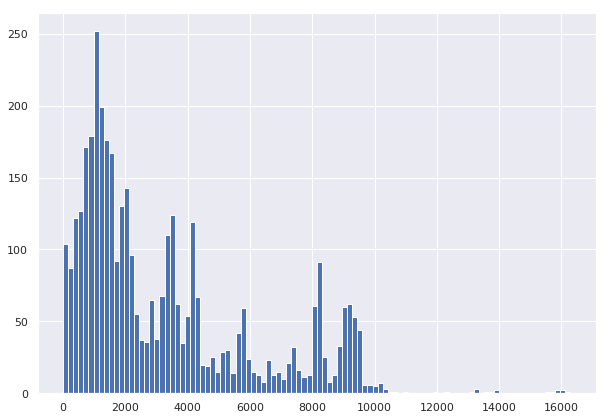

In [35]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

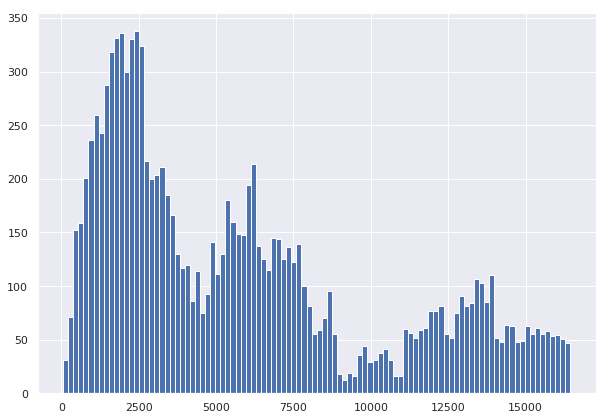

In [36]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

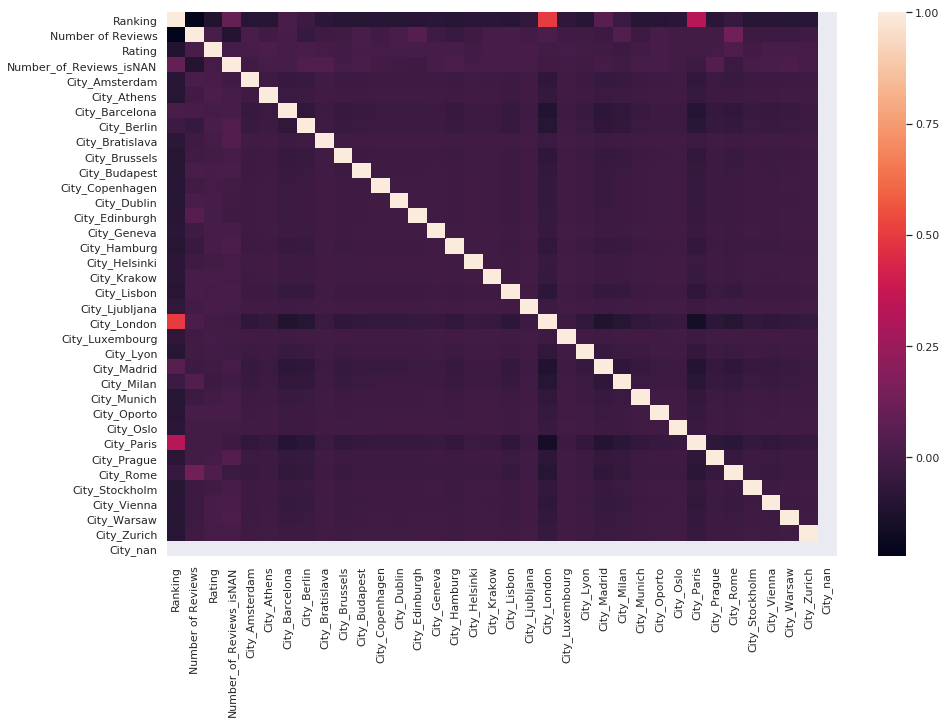

In [38]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [ ]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

In [ ]:
df_preproc.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
